# MNIST GAN - Tutorial

This notebook trains a Generative Adversarial Network (GAN) on the MNIST dataset. The GAN consists of a Generator and a Discriminator, both implemented as PyTorch modules. The Generator model generates new images from random noise, and the Discriminator model attempts to distinguish between real images from the MNIST dataset and generated images. The models are trained in an adversarial manner, with the Generator trying to fool the Discriminator and the Discriminator trying to correctly classify real vs. fake.
This code is adapted from: https://github.com/sw-song/PyTorch-GAN/blob/master/implementations/gan/gan.py


## Instructions:

Throughout the notebook you will find comments like `# Put your code here`. In those cases, you are expected to complete the code appropriately.

* Training time should take around 15 minutes with a GPU.

In [1]:
import os
import numpy as np
import random
import matplotlib.pyplot as plt
from IPython.display import Image
from tqdm import tqdm


import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch
from torchsummary import summary


Setting the seed

**Why 42?** <br>
It is the  [Answer to the Ultimate Question of Life, the Universe, and Everything](https://en.wikipedia.org/wiki/Phrases_from_The_Hitchhiker%27s_Guide_to_the_Galaxy#Answer_to_the_Ultimate_Question_of_Life,_the_Universe,_and_Everything_(42)) 😆 !


In [2]:
def set_seed(seed):
    """Set seed"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    print(f'Set seed {seed}')

set_seed(42)  # Use any number you like here

Set seed 42


## Set up training parameters
Let's define the hyperparameters for the training process

In [7]:
# Define the parameters for the training process
n_epochs = 50
batch_size = 128
lr = 0.0002
latent_dim = 50 #dimension of the distribution space
img_size = 28
channels = 1

In [8]:
# Create a directory to save generated images
os.makedirs("mnist_images", exist_ok=True)

# Image dimensions
img_shape = (channels, img_size, img_size)

# Check if a GPU is available and if not, use a CPU
cuda = True if torch.cuda.is_available() else False
print(cuda)

False


## Training Data

As previously mentioned, we will start with a simple approach. Our initial step involves utilizing the MNIST dataset, while constructing the Generator and Discriminator models using linear layers. <br>

By leveraging the MNIST dataset, we can effectively demonstrate the capabilities of our models, showcasing their ability to generate realistic samples. The linear layers within the Generator and Discriminator will form the foundation of our implementation, allowing us to progressively build upon this foundation as we delve deeper into the problem at hand.

For this example, we create a data loader for the MNIST dataset, which is a dataset of handwritten digits commonly used in machine learning. This data loader will be used to serve up the dataset in batches during the training of a model.

## Question: What is the range of values of each pixel in the images?

* After the `transform=..` instruction, each pixel has values in the range [-1,1]. This is an important consideration for the design of the generator.

In [9]:
# Create a directory to store the MNIST dataset.
# 'exist_ok=True' makes sure the command does not fail if the directory already exists.
os.makedirs("mnist/data", exist_ok=True)

# Create a DataLoader to handle batching of the MNIST dataset.
dataloader = torch.utils.data.DataLoader(

    # Load the MNIST dataset from PyTorch's built-in datasets.
    datasets.MNIST(
        # Set the directory where the data is stored or where it will be downloaded.
        "mnist/data",
        # Use the training portion of the dataset.
        train=True,
        # Download the dataset if it is not already in the specified directory.
        download=True,
        # Apply several transformations to the images in the dataset:
        transform=transforms.Compose(
            [
                # Resize images to the size specified by the 'img_size' variable.
                transforms.Resize(img_size),
                # Convert images from PIL format to PyTorch tensors.
                transforms.ToTensor(),
                # Normalize tensors so that the pixel intensity values have a mean of 0.5 and a standard deviation of 0.5.
                transforms.Normalize([0.5], [0.5])
            ]
        ),
    ),

    # Set the number of samples per batch to load.
    batch_size=batch_size,
    # Enable shuffling to feed data points in a random manner.
    shuffle=True,
)


Visualize how my training data looks like

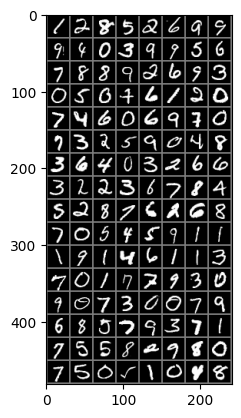

In [10]:
# Get a batch of training images
dataiter = iter(dataloader)
images, labels = next(dataiter)

# Function to unnormalize and bring back the pixel values to (0, 1)
# Since normalized: (image - mean) / std_deviation, therefore, to bring back: image = (normalized * std_deviation) + mean
def imshow(img):
    img = img / 2 + 0.5  # unnormalize back to range [0, 1]
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # Transpose to put channel last (which is the expected format for matplotlib)
    plt.show()

# Make a grid from the batch and show it
imshow(torchvision.utils.make_grid(images))

In [11]:
num_samples = len(dataloader.dataset)
print(f'There are {num_samples} samples in the DataLoader.')

There are 60000 samples in the DataLoader.


## Define the Generator and Discriminator models

We'll implement the Generator and Discriminator as PyTorch modules. The Generator will take in a noise vector and output an image, while the Discriminator will take in an image and output a probability indicating whether the image is real or fake.

In [12]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        # Function to create a linear layer block (Linear -> BatchNorm (optional) -> LeakyReLU)
        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]  # Linear transformation
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))  # Batch normalization
            layers.append(nn.LeakyReLU(0.2, inplace=True))  # LeakyReLU activation
            return layers

        # Using the block function, we create the architecture of the generator
        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False),  # First layer block
            *block(128, 256),  # Second layer block
            *block(256, 512),  # Third layer block
            *block(512, 1024),  # Fourth layer block
            nn.Linear(1024, int(np.prod(img_shape))),  # Final linear layer
            nn.Tanh()  #  put your code here. We need an activation function. What would be the most appropriate? Hint: either nn.Sigmoid() or nn.Tanh(). Other Hint: Look at the question stated in the "Traning Data" section above.
            )

    def forward(self, z):  # Forward propagation function
        img = self.model(z)  # Pass input through the model
        img = img.view(img.size(0), *img_shape)  # Reshape the output to image shape
        return img  # Return the im

In [13]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        # The architecture of the discriminator is simpler and doesn't include batch normalization
        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),  # Linear transformation
            nn.LeakyReLU(0.2, inplace=True),  # LeakyReLU activation
            nn.Linear(512, 256),  # Another linear transformation
            nn.LeakyReLU(0.2, inplace=True),  # LeakyReLU activation
            nn.Linear(256, 1),  # Final linear transformation to output a single value
            nn.Sigmoid(),  #put your code here. We need an activation function. What would be the most appropriate? Hint: either nn.Sigmoid() or nn.Tanh()
            )

    def forward(self, img):  # Forward propagation function
        img_flat = img.view(img.size(0), -1)  # Flatten the image
        validity = self.model(img_flat)  # Pass the flattened image through the model
        return validity  # Return the validity

Loss Function

| Formulation                                                                       | Discriminator Loss ($L_D$)                                                                                                                                                        | Generator Loss ($L_G$)                   |
|--------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|-----------------------------------------------------|
| MinMax       | $-\mathbb{E}_{x\sim p_d} [\log(D(x))]- \mathbb{E}_{\hat{x}\sim p_g} [\log (1-D(\hat{x}))]$ | $\mathbb{E}_{\hat{x}\sim p_g} [\log (1-D(\hat{x}))]$                                                                                                                                       |
| Non-Saturating                                                                             | $ -\mathbb{E}_{x\sim p_d} [\log(D(x))]+\mathbb{E}_{\hat{x}\sim p_g} [\log (D(\hat{x}))]$                                                                                                   | $-\mathbb{E}_{\hat{x}\sim p_g} [\log (D(\hat{x}))]$ |
| WGAN-GP                                                                                    | $-\mathbb{E}_{x\sim p_d} [D(x)] + \mathbb{E}_{\hat{x}\sim p_g} [D(\hat{x})] + \lambda \mathbb{E}_{\hat{x} \sim p_{g}} \left[(\|\nabla D(\alpha x + (1-\alpha \hat{x})) \|_2 -1)^2 \right]$ | $-\mathbb{E}_{\hat{x}\sim p_g} [D(\hat{x})]$        |


In [14]:
# We use binary cross-entropy loss for the adversarial loss function (similar to min-max)
adversarial_loss = torch.nn.BCELoss() #put your code here. Hint: look at the slides

# Initialize the generator and the discriminator
generator = Generator()
discriminator = Discriminator()

# If CUDA is available, we use it for the models and the loss function
if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()


# We use the Adam optimizer for both the generator and the discriminator
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

#
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

print(generator)
print(discriminator)

Generator(
  (model): Sequential(
    (0): Linear(in_features=50, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): BatchNorm1d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Linear(in_features=256, out_features=512, bias=True)
    (6): BatchNorm1d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Linear(in_features=512, out_features=1024, bias=True)
    (9): BatchNorm1d(1024, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Linear(in_features=1024, out_features=784, bias=True)
    (12): Tanh()
  )
)
Discriminator(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)


## Training Loop

In [ ]:
# Initialize list to store losses for Generator and Discriminator
g_losses = []
d_losses = []

# Training Loop
for epoch in tqdm(range(n_epochs)):  # Loop over the dataset multiple times, for each epoch
    g_loss_accum = 0.0
    d_loss_accum = 0.0
    num_batches = 0
    for i, (imgs, _) in enumerate(dataloader):  # Loop over each batch of real images in the dataset

        # Ground truth labels for real and fake images (real: 1, fake: 0)
        valid = Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.size(0), 1).fill_(0.0), requires_grad=False)

        # Configure input, this will be used for training the discriminator with real images
        real_imgs = Variable(imgs.type(Tensor))

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()  # Clears the gradients of all optimized tensors

        # Sample noise as generator input
        noise_vector_shape = (imgs.shape[0], latent_dim) # put your code here. Hint, look at the generator definition.
        z = Variable(Tensor(np.random.normal(0, 1, noise_vector_shape)))

        # Generate a batch of images from the noise
        gen_imgs = generator(z)

        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)

        g_loss.backward()  # Compute the gradient of g_loss w.r.t. the Generator's parameters
        optimizer_G.step()  # Update the Generator's weights

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()  # Clears the gradients of all optimized tensors

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(real_imgs), valid)  # Loss for real images
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)  # Loss for fake images
        d_loss = (real_loss + fake_loss) / 2  # Take the average of these two losses

        d_loss.backward()  # Compute the gradient of d_loss w.r.t. the Discriminator's parameters
        optimizer_D.step()  # Update the Discriminator's weights

        # Accumulate losses for this batch
        g_loss_accum += g_loss.item()
        d_loss_accum += d_loss.item()
        num_batches += 1

    # Save average losses for this epoch
    g_losses.append(g_loss_accum / num_batches)
    d_losses.append(d_loss_accum / num_batches)

    # Save a batch of generated images every 10 epochs
    if epoch % 5 == 0:
        save_image(gen_imgs.data[:25], f"mnist_images/epoch_{epoch}.png", nrow=5, normalize=True)


  0%|          | 0/50 [00:00<?, ?it/s]

Plot the losses

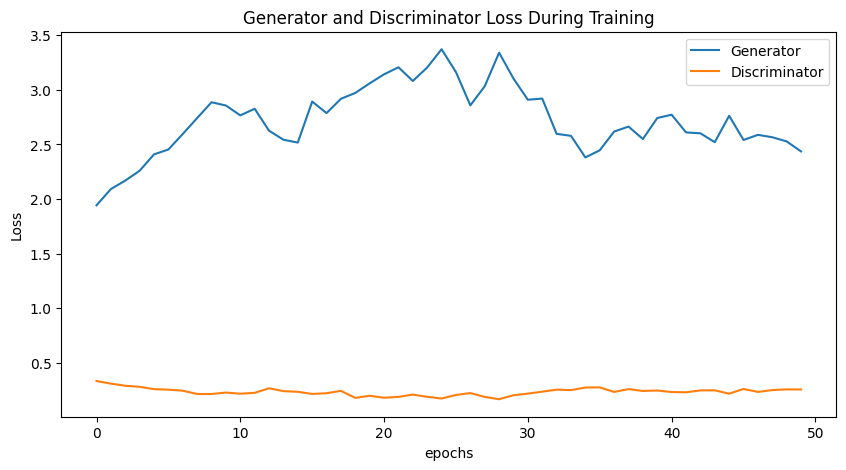

In [ ]:
# Plotting the losses
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(g_losses,label="Generator")
plt.plot(d_losses,label="Discriminator")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

Plot samples generated

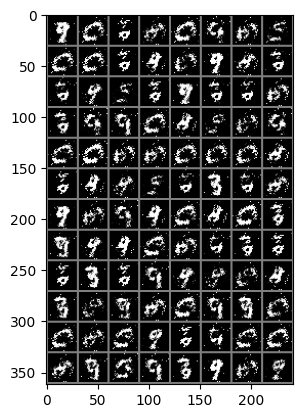

In [ ]:
# Make a grid from the batch and show it (generated data)
imshow(torchvision.utils.make_grid(gen_imgs.detach().cpu()))

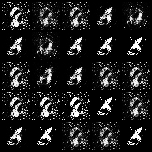

In [ ]:
import os
import glob
from PIL import Image
from IPython.display import Image as IPyImage
from IPython.display import display

# Path to the folder containing the images
folder_path = "mnist_images/"

# Get a list of image file paths in the folder
image_files = sorted(glob.glob(os.path.join(folder_path, "*.png")))  # Replace "*.jpg" with the appropriate file extension

# Create a list to store the image objects
images = []

# Iterate over the image files and open each image
for image_file in image_files:
    image = Image.open(image_file)
    images.append(image)

# Save the images as a GIF file
output_path = "mnist_images/output.gif"
images[0].save(output_path, save_all=True, append_images=images[1:], duration=500, loop=0)

# Display the GIF
display(IPyImage(filename=output_path))
